## Importação de Bibliotecas

In [587]:
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import seaborn as sns

## Seleção

In [588]:
df = pd.read_csv("../data/sales_pizza_2023.csv")
df.head()

,DATE,COUNT
0,2023-01-01,0
1,2023-01-02,148
2,2023-01-03,157
3,2023-01-04,153
4,2023-01-05,134


In [589]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    365 non-null    object
 1   COUNT   365 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.8+ KB


In [590]:
df.describe()

,COUNT
count,365.000000
mean,108.334247
std,48.651238
min,0.000000
25%,74.000000
50%,101.000000
75%,137.000000
max,265.000000


## Pré-Processamento

Usaremos a função `fillna` para preencher valores **ausentes** com a **média** dos valores da coluna `COUNT`.

In [591]:
df["COUNT"] = df["COUNT"].fillna(df["COUNT"].mean())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    365 non-null    object
 1   COUNT   365 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.8+ KB


Para remover **outliers**, usaremos o **intervalo interquartil**.

In [592]:
q1 = df["COUNT"].quantile(0.25)
q3 = df["COUNT"].quantile(0.75)
iqr = q3 - q1

df = df[(df["COUNT"] > q1 - 1.5 * iqr) & (df["COUNT"] < q3 + 1.5 * iqr)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 363 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    363 non-null    object
 1   COUNT   363 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.5+ KB


Observe que, anteriomente, haviam 365 entradas e agora, após a remoção dos outliers, existem 363 entradas.

## Transformação

Após o pré-processamento dos dados, iremos salvar eles em um arquivo binário usando a biblioteca `pickle` para que possam ser usados futuramente sem que seja necessário fazer o processo novamente.

In [593]:
with Path.open("../data/sales_pizza_2023_processed.pkl", "wb") as f:
    pickle.dump(df, f)

Usaremos a função `to_datetime` para converter o tipo da coluna `DATE` de `object` para `datetime64`.

In [594]:
df["DATE"] = pd.to_datetime(df["DATE"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 363 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    363 non-null    datetime64[ns]
 1   COUNT   363 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 8.5 KB


Criaremos uma coluna chamada `DAYS` para armazenar a contagem de dias a partir da menor data registrada.

In [595]:
df["DAYS"] = (df["DATE"] - df["DATE"].min()).dt.days
df.head()

,DATE,COUNT,DAYS
0,2023-01-01,0,0
1,2023-01-02,148,1
2,2023-01-03,157,2
3,2023-01-04,153,3
4,2023-01-05,134,4


## Mineração de Dados

Usaremos a classe `LinearRegression` da biblioteca `sklearn` para criar um objeto `model` e então usaremos a função `fit` para ajustar uma reta aos dados.

In [596]:
model = LinearRegression()
model.fit(df[["DAYS"]], df["COUNT"])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


Usaremos também a função `linear_regression` para ajustar uma reta aos dados de forma manual.

In [597]:
def linear_regression(x_values: [], y_values: []) -> (float, float):
    best_sum = float("inf")
    best_a = 0
    best_b = 0

    a_range = np.arange(-5, 5, 0.1) # Revisar
    b_range = np.arange(0, 250, 1) # Revisar

    for a in a_range:
        for b in b_range:
            squared_residuals = []

            for x, y in zip(x_values, y_values, strict=True):
                squared_residuals.append((((a * x + b) - y) ** 2) ** (1/2))

            sum_of_squared_residuals = sum(squared_residuals)

            if sum_of_squared_residuals < best_sum:
                best_a = a
                best_b = b
                best_sum = sum_of_squared_residuals

    return best_a, best_b

a, b = linear_regression(df["DAYS"], df["COUNT"])

Usaremos o objeto `model` para prever os valores e criaremos uma lista com os valores previstos através da função da reta com os coeficientes `a` e `b` retornados pela função `linear_regression`.

In [598]:
predicted_values_sklearn = model.predict(df[["DAYS"]])
predicted_values_manual = [a * x + b for x in range(df.shape[0])]

## Avaliação

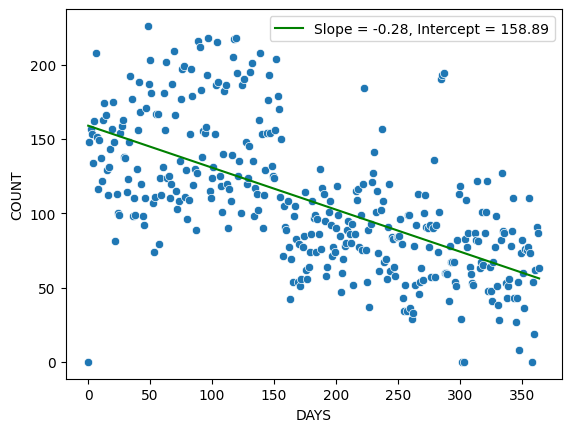

In [599]:
sns.scatterplot(df, x="DAYS", y="COUNT")
sklearn_line, = plt.plot(df["DAYS"], predicted_values_sklearn, c="green")
plt.legend([sklearn_line], [f"Slope = {model.coef_[0]:.2f}, Intercept = {model.intercept_:.2f}"])

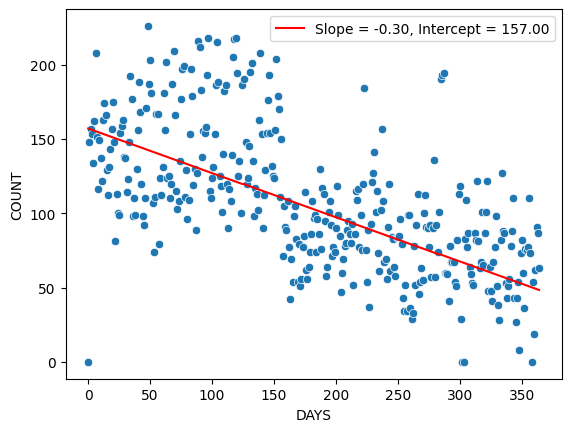

In [600]:
sns.scatterplot(df, x="DAYS", y="COUNT")
manual_line, = plt.plot(df["DAYS"], predicted_values_manual, c="red")
plt.legend([manual_line], [f"Slope = {a:.2f}, Intercept = {b:.2f}"])